In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
os.chdir('/Users/juliette/Documents/repos/SDS383D_JF/exercises-03')
from python_code import homoskedastic_model as hsk
from python_code import gibbs_sampler as gs
import matplotlib.style as style
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import pickle
import scipy.stats as stats
from scipy.stats import norm
#plot res against market rent

In [2]:
df=pd.read_csv('../data/greenbuildings.csv')
y = ((df['Rent']*df['leasing_rate'])/100).to_numpy()
X = df[['green_rating', 'City_Market_Rent', 'age','class_a', 'class_b']].to_numpy()
X_intercept = sm.add_constant(X)

## fit with sklearn

In [3]:
reg = LinearRegression().fit(X, y)
betas_sklearn = np.concatenate((reg.intercept_.flatten(), reg.coef_.flatten()))
# calculate confidence interval using ex 1 (assume normal residuals)
var  = np.var(y - X_intercept@betas_sklearn, ddof=len(betas_sklearn))
cov_matrix = var*np.linalg.inv(X_intercept.T@X_intercept)
se = np.sqrt(np.diag(cov_matrix))
t_crit = norm(0, 1).ppf(1-0.025)
conf_low = betas_sklearn -t_crit*se
conf_up = betas_sklearn+t_crit*se

## fit with Gibbs

In [5]:
gibbs = gs.GibbsSampler(X, y, n_iter=1000, n_to_discard=100, fit_intercept=True, h=1)
gibbs.fit()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.22it/s]


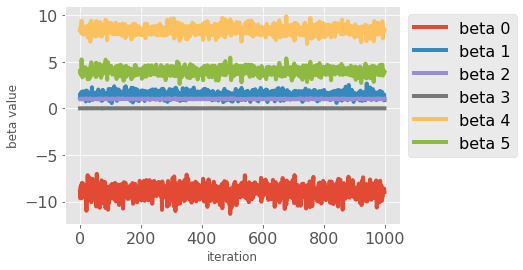

In [6]:
for i in range(len(gibbs.coefs)):
    plt.plot(gibbs.traces['beta_trace'][:,i], label=f'beta {i}');
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('iteration')
plt.ylabel('beta value');

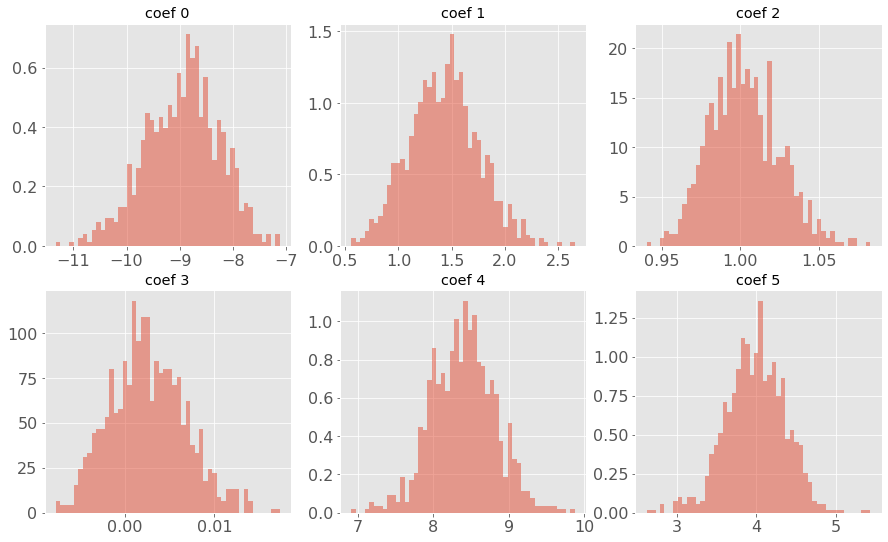

In [7]:
gibbs.plot_coefs_histograms();

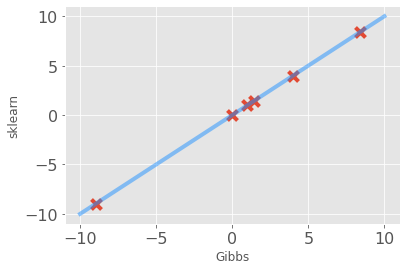

In [8]:
plt.scatter(gibbs._calculate_averaged_coefficients(), betas_sklearn, s=100, marker='x')
plt.plot([-10,10],[-10,10],color='dodgerblue', alpha=.5)
plt.xlabel('Gibbs')
plt.ylabel('sklearn');

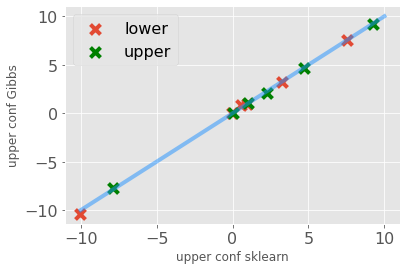

In [9]:
gibbs_intervals = gibbs.calculate_confidence_intervals()
plt.plot([-10,10],[-10,10],color='dodgerblue', alpha=.5)
plt.scatter(conf_low, gibbs_intervals[0],s=100, marker='x', label='lower')
plt.xlabel('lower conf sklearn')
plt.ylabel('lower conf Gibbs')
plt.scatter(conf_up, gibbs_intervals[1],s=100, marker='x', label='upper', color='green')
plt.xlabel('upper conf sklearn')
plt.ylabel('upper conf Gibbs')
plt.legend();

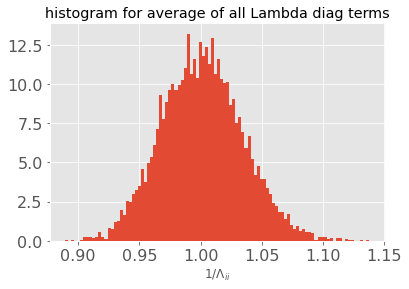

In [10]:
plt.hist(1/gibbs.traces_kept['Lambda_trace'].mean(axis=0), density=True, bins=100);
plt.title('histogram for average of all Lambda diag terms');
plt.xlabel('1/$\Lambda_{ii}$');

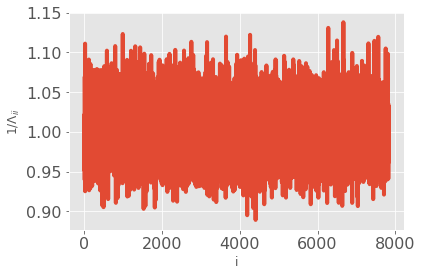

In [11]:
plt.plot(1/gibbs.traces_kept['Lambda_trace'].mean(axis=0));
plt.ylabel('1/$\Lambda_{ii}$');
plt.xlabel('i');

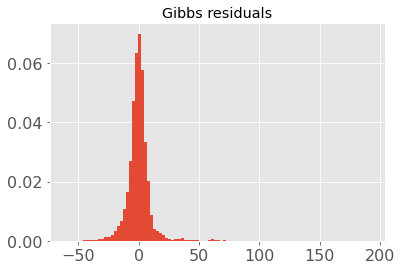

In [12]:
residuals = -(gibbs.predict(X)-y)
plt.hist(residuals, bins=100, density=True);
plt.title('Gibbs residuals');

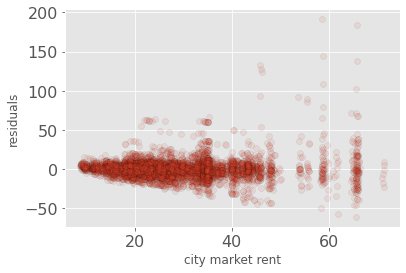

In [13]:
plt.scatter(df['City_Market_Rent'], residuals, alpha =0.1, edgecolor='black')
plt.xlabel('city market rent')
plt.ylabel('residuals');

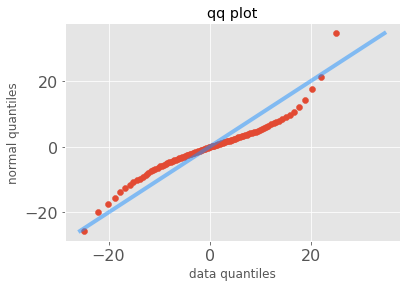

In [14]:
quantiles = np.linspace(1e-2,1-1e-2,100)
theoretical = norm(loc=residuals.mean(), scale=residuals.std()).ppf(quantiles)
actual = np.quantile(residuals, quantiles)
plt.scatter(theoretical,actual)
plt.plot([actual.min(), actual.max()],[actual.min(), actual.max()], color='dodgerblue', alpha=0.5);
plt.title('qq plot')
plt.xlabel('data quantiles')
plt.ylabel('normal quantiles');

## fit with homoskedastic

In [15]:
model = hsk.HomoskedasticModel(X, y)
model.fit()
model.coefs

array([-8.96341766e+00,  1.42220244e+00,  1.00299784e+00,  2.65262217e-03,
        8.40442393e+00,  3.99152525e+00])

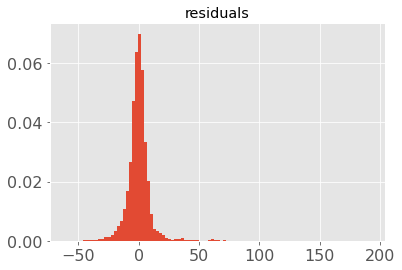

In [16]:
residuals = -(model.predict(X) - y)
plt.hist(residuals, bins=100, density=True)
plt.title('residuals');

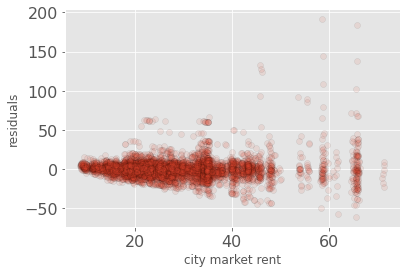

In [17]:
plt.scatter(df['City_Market_Rent'], residuals, alpha =0.1, edgecolor='black')
plt.xlabel('city market rent')
plt.ylabel('residuals');

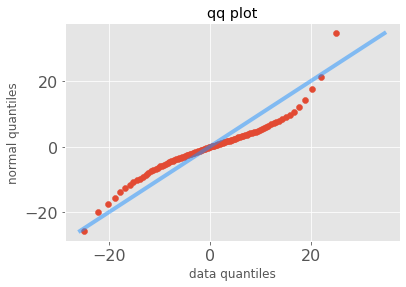

In [18]:
quantiles = np.linspace(1e-2,1-1e-2,100)
theoretical = norm(loc=residuals.mean(), scale=residuals.std()).ppf(quantiles)
actual = np.quantile(residuals, quantiles)
plt.scatter(theoretical,actual)
plt.plot([actual.min(), actual.max()],[actual.min(), actual.max()], color='dodgerblue', alpha=0.5);
plt.title('qq plot')
plt.xlabel('data quantiles')
plt.ylabel('normal quantiles');

In [19]:
conf_interval = model.calculate_confidence_interval(num_samples=1000)

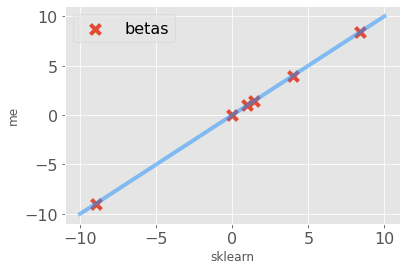

In [20]:
plt.scatter(betas_sklearn, model.coefs, label='betas', marker='x', s=100)
plt.plot([-10,10],[-10,10],color='dodgerblue', alpha=.5)
plt.xlabel('sklearn')
plt.ylabel('me')
plt.legend();

In [21]:
# or with statsmodels
est = sm.OLS(y, X_intercept)
conf = est.fit().conf_int(alpha=0.05, cols=None)

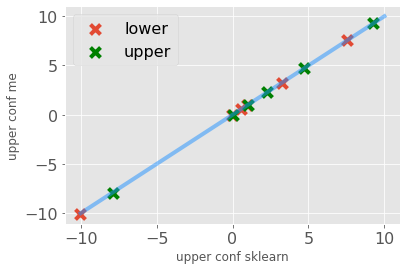

In [22]:
plt.plot([-10,10],[-10,10],color='dodgerblue', alpha=.5)
plt.scatter(conf_low, conf_interval[0],s=100, marker='x', label='lower')
plt.xlabel('lower conf sklearn')
plt.ylabel('lower conf me')
plt.scatter(conf_up, conf_interval[1],s=100, marker='x', label='upper', color='green')
plt.xlabel('upper conf sklearn')
plt.ylabel('upper conf me')
plt.legend();